In [202]:
import fbprophet
import numpy as np
import pandas as pd
import re
import seaborn as sns
import psycopg2
from datetime import datetime
from datetime import date
from datetime import timedelta
from matplotlib import pyplot as plt


In [203]:
#CREATING A DB

start_date = date(2021, 12, 1)
end_date = date(2022, 2,11)
delta = (end_date - start_date).days
today = pd.to_datetime('today').normalize()


time = pd.DataFrame(pd.date_range(start=start_date,end=end_date).to_pydatetime().tolist(),
                  columns=list('a'))

observation = pd.DataFrame(np.random.randint(100,125,size=(delta, 1)), columns=list('y'))
                           

df = pd.concat([time,observation],axis=1)

df.rename(columns={"a": "ds"}, inplace=True)
df.drop_duplicates(subset=['ds'], keep='first', inplace=True)

df['ds'] = pd.to_datetime(df['ds'])
df_pred = df.copy()

#df.head()



In [204]:
#identifying the outliers - Interquartile method
Q1 = df_pred['y'].quantile(0.3)
Q3 = df_pred['y'].quantile(0.6)
IQR = Q3 - Q1

whisker_width = 0.5 

lower_whisker = Q1 - (whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)

outliers = df_pred[(df_pred['y'] < lower_whisker) | (df_pred['y'] > upper_whisker)]

cap = df_pred.y.max()
flr = df_pred.y.min()
df_pred['cap'] = cap
df_pred['floor'] = flr


In [205]:
##Setting up the model

from fbprophet import Prophet
# define the model
model = Prophet(   #growth = 'logistic',
                #yearly_seasonality = True, 
             #weekly_seasonality = True,
               #daily_seasonality = True
               )

# fitting the model

model.fit(df_pred)

future = model.make_future_dataframe(periods=19, freq = 'd')
#future['cap'] = cap
#future['floor'] = flr
#m.add_country_holidays(country_name='IT')

forecast = model.predict(future)
forecast = forecast[['ds', 'yhat']] 

frames = [df_pred, forecast]

result = pd.concat(frames) 
result = result.fillna(0)

result_exp = result.groupby(["ds"]).agg(y_actual=('y', 'sum'), y_predicted=('yhat', 'sum')).reset_index()

result_exp

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y_actual,y_predicted
0,2021-12-01,101.0,105.577721
1,2021-12-02,112.0,110.576795
2,2021-12-03,104.0,105.548160
3,2021-12-04,110.0,106.747319
4,2021-12-05,124.0,112.246388
...,...,...,...
87,2022-02-26,0.0,111.730161
88,2022-02-27,0.0,117.230741
89,2022-02-28,0.0,114.631451
90,2022-03-01,0.0,112.332156


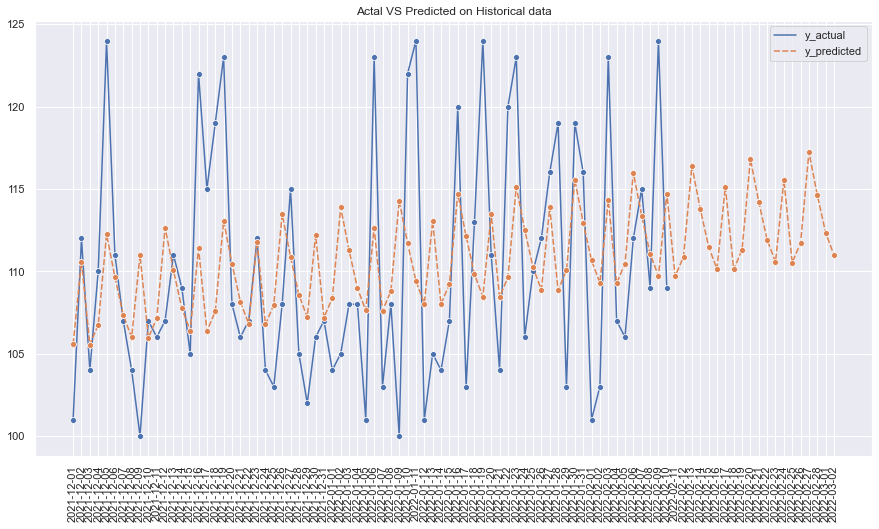

In [219]:
from matplotlib import pyplot as plt

result_full = result_exp.copy()
result_full['y_actual'] = result_full['y_actual'].replace(0, np.nan)
a = sns.lineplot(data=result_full, marker='o', )

a.set_xticks(range(len(result_full.ds))) # <--- set the ticks first
a.set_xticklabels(pd.to_datetime(result_full['ds'], errors='coerce').dt.to_period('d'), rotation=90)

a.set_title('Actal VS Predicted on Historical data')

plt.savefig('prediction_blog.png')

<AxesSubplot:title={'center':'Actal VS Predicted on Historical data'}>

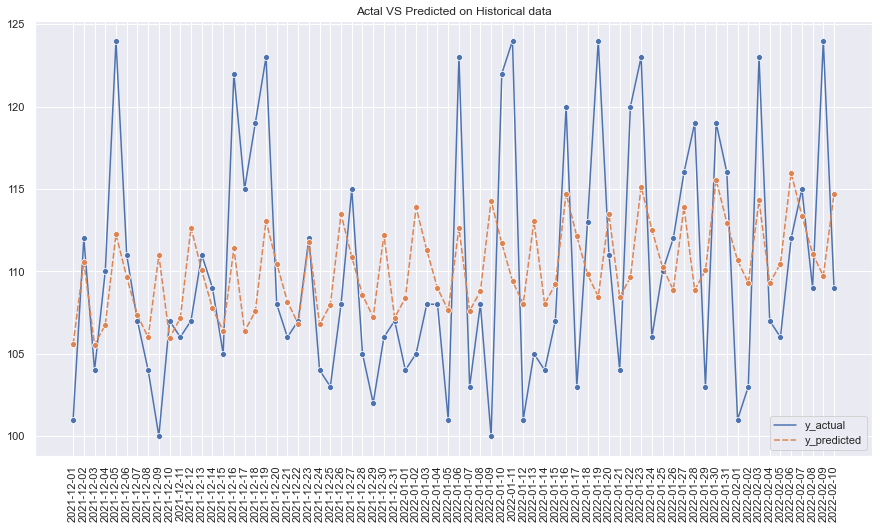

In [212]:
##Evaluate the prediction error
today_minus_one = date.today() + timedelta(days=-1)

plot = result_exp[(result_exp.ds < today)]

#plot = result_exp.y_actual.replace('0',np.nan)

sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")


g = sns.lineplot(data=plot, marker='o', )

g.set_xticks(range(len(plot.ds))) # <--- set the ticks first
g.set_xticklabels(pd.to_datetime(plot['ds'], errors='coerce').dt.to_period('d'), rotation=90)

g.set_title('Actal VS Predicted on Historical data')
g

In [226]:
# Calculating MAPE
mape = np.mean(np.abs(plot.y_actual - plot.y_predicted)/np.abs(plot.y_predicted))
print(round((mape*100),2), " %")

4.77  %
